<a href="https://www.kaggle.com/code/hzjsjs/fastai?scriptVersionId=128936135" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from PIL import Image
import os
import csv
import shutil


In [1]:
!pip list | grep -e fastai -e torch -e torchvision

fastai                                 2.7.12
pytorch-ignite                         0.4.11
pytorch-lightning                      2.0.1.post0
torch                                  2.0.0
torchaudio                             2.0.1
torchdata                              0.6.0
torchinfo                              1.7.2
torchmetrics                           0.11.4
torchtext                              0.15.1
torchvision                            0.15.1


In [5]:


# Define the paths to the CSV file and image directory
csv_file = '/kaggle/input/isic25kgt/ISIC_2019_Training_GroundTruth.csv'
image_dir = '/kaggle/input/isicdataset2019/ISIC_2019_Training_Input'

# Define the paths to the output directories
output_dir = '/kaggle/working/train/'

# Create the output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)

# Read the CSV file and get the label column names
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # Get the header row
    label_cols = header[1:]  # Get the label column names

# Create a directory for each label column
label_dirs = [os.path.join(output_dir, col) for col in label_cols]
for label_dir in label_dirs:
    os.makedirs(label_dir, exist_ok=True)

# Iterate over the rows of the CSV file and copy the images to the appropriate label folder
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row
    for row in reader:
        image_name = row[0]  # Get the image filename
        labels = row[1:]  # Get the label values
       
        # Add the file extension
        image_name_with_extension = image_name + '.jpg'

        # Copy the image to the appropriate label directory
        for i, label in enumerate(labels):
            if label == '1.0':
                label_dir = label_dirs[i]
                src_path = os.path.join(image_dir, image_name_with_extension)
                dst_path = os.path.join(label_dir, image_name_with_extension)
                shutil.copy(src_path, dst_path)

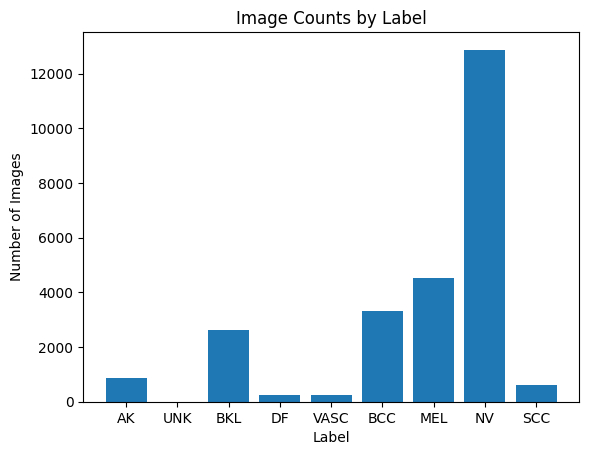

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the output directory
output_dir = '/kaggle/working/train/'

label_list = ['UNK', 'AK', 'DF', 'MEL', 'NV', 'VASC', 'BCC', 'BKL', 'SCC']

# Get a list of the label directories that match the label list
label_dirs = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d)) and d in label_list]

# Iterate over the label directories and count the number of images in each directory
counts = []
labels = []
for label_dir in label_dirs:
    num_images = len(os.listdir(label_dir))
    counts.append(num_images)
    labels.append(os.path.basename(label_dir))

# Create a bar chart of the image counts by label
plt.bar(labels, counts)
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Image Counts by Label')
plt.show()

In [7]:
os.rmdir('/kaggle/working/train/UNK')

In [8]:
DATASET_PATH = '/kaggle/working/train'

In [10]:
class_names = []
for folder_name in os.listdir(DATASET_PATH):
    class_names.append(folder_name)

In [11]:
print(class_names)

['AK', 'BKL', 'DF', 'VASC', 'BCC', 'MEL', 'NV', 'SCC']


In [12]:
image_paths = []
labels = []

for i in range(len(class_names)):
    class_name = class_names[i]
    image_names = os.listdir(f'{DATASET_PATH}/{class_name}')
    for image_name in image_names:
        image_path = f'{DATASET_PATH}/{class_name}/{image_name}'
        image_paths.append(image_path)
        labels.append(i)
print(image_paths)
print(labels)

['/kaggle/working/train/AK/ISIC_0065476.jpg', '/kaggle/working/train/AK/ISIC_0069869.jpg', '/kaggle/working/train/AK/ISIC_0067304.jpg', '/kaggle/working/train/AK/ISIC_0071671.jpg', '/kaggle/working/train/AK/ISIC_0069282.jpg', '/kaggle/working/train/AK/ISIC_0069352.jpg', '/kaggle/working/train/AK/ISIC_0062692.jpg', '/kaggle/working/train/AK/ISIC_0068722.jpg', '/kaggle/working/train/AK/ISIC_0030730.jpg', '/kaggle/working/train/AK/ISIC_0032437.jpg', '/kaggle/working/train/AK/ISIC_0031335.jpg', '/kaggle/working/train/AK/ISIC_0064553.jpg', '/kaggle/working/train/AK/ISIC_0063100.jpg', '/kaggle/working/train/AK/ISIC_0065150.jpg', '/kaggle/working/train/AK/ISIC_0025780.jpg', '/kaggle/working/train/AK/ISIC_0058776.jpg', '/kaggle/working/train/AK/ISIC_0071339.jpg', '/kaggle/working/train/AK/ISIC_0028619.jpg', '/kaggle/working/train/AK/ISIC_0065628.jpg', '/kaggle/working/train/AK/ISIC_0067647.jpg', '/kaggle/working/train/AK/ISIC_0058593.jpg', '/kaggle/working/train/AK/ISIC_0070643.jpg', '/kaggle/

In [13]:
df = pd.DataFrame(
    {
        'name': image_paths,
        'label': labels
    }
)

In [14]:
df.head()

,name,label
0,/kaggle/working/train/AK/ISIC_0065476.jpg,0
1,/kaggle/working/train/AK/ISIC_0069869.jpg,0
2,/kaggle/working/train/AK/ISIC_0067304.jpg,0
3,/kaggle/working/train/AK/ISIC_0071671.jpg,0
4,/kaggle/working/train/AK/ISIC_0069282.jpg,0


In [15]:
df.tail()

,name,label
25326,/kaggle/working/train/SCC/ISIC_0072499.jpg,7
25327,/kaggle/working/train/SCC/ISIC_0069266.jpg,7
25328,/kaggle/working/train/SCC/ISIC_0060353.jpg,7
25329,/kaggle/working/train/SCC/ISIC_0054660.jpg,7
25330,/kaggle/working/train/SCC/ISIC_0059575.jpg,7


In [16]:
df.to_csv(
    path_or_buf=f'{DATASET_PATH}/labels.csv',
    index=False
)

In [18]:
df.tail()

,name,label
25326,/kaggle/working/train/SCC/ISIC_0072499.jpg,7
25327,/kaggle/working/train/SCC/ISIC_0069266.jpg,7
25328,/kaggle/working/train/SCC/ISIC_0060353.jpg,7
25329,/kaggle/working/train/SCC/ISIC_0054660.jpg,7
25330,/kaggle/working/train/SCC/ISIC_0059575.jpg,7


In [20]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd

In [21]:
dls = ImageDataLoaders.from_folder(
    path=DATASET_PATH,
    item_tfms=Resize(224),
    bs=16,
    batch_tfms=[Normalize.from_stats(*imagenet_stats), RandTransform()],
    valid_pct=0.2
)

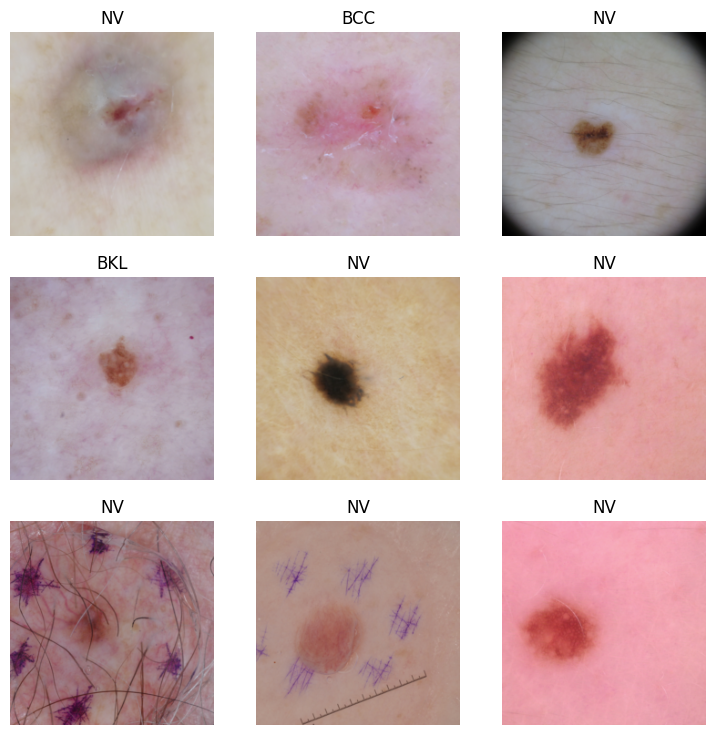

In [23]:
dls.show_batch()

In [24]:
model = vision_learner(
    dls=dls,
    arch=models.resnet50,
    metrics=[accuracy, error_rate]
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


In [25]:
model.fine_tune(
    epochs=15,
    base_lr = 0.0012
)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.112149,0.946092,0.661863,0.338137,10:24


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.777496,0.665495,0.761548,0.238452,10:27


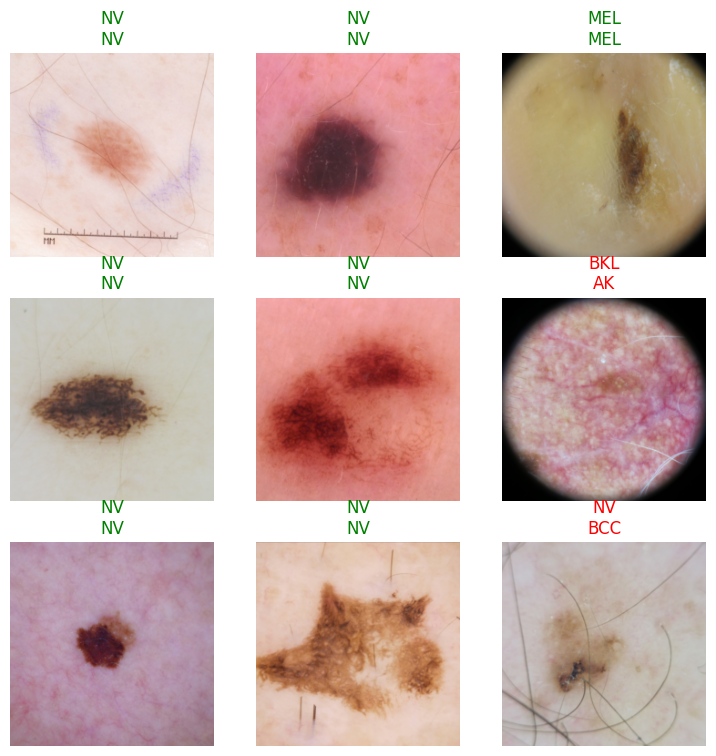

In [30]:
model.show_results()